In [1]:
# %load ./include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import trange,tqdm
sys.path.append('./include')
import ml4s
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('./include/notebook.mplstyle')
np.set_printoptions(linewidth=120)
ml4s._set_css_style('./include/bootstrap.css')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
π = np.pi

# Accelerating Monte Carlo via Restricted Boltzmann Machines

## Introduction

Monte Carlo is one of the most common methods of simulating models in condensed matter physics. The idea is to start with a lattice at high temperature, and propose random spin flips on the lattice. Broadly, we see if the spin flip results in a reduction of the energy of the lattice; if does the flip is accepted, otherwise, it may be accepted with a certain probability. However, this also makes it a lengthy process where a large number of updates are lost to thermalization, as well as large fluctuations occuring near the critical point. Sophisticated techniques exist to "intelligently" guess an update that will lead to lower autocorrelation times. In this project, I have taken a simplified approach where the neural network learns the distribution of states at a given temperature and propose a likely state that we obtain at the end of thermalization, thereby cutting down the thermalization time.

## Data set

For data, I will be using the Ising model configurations on the 30x30 lattice used for our class and home assignments. From that, I will select a particluar temperature below the (known) critical point.

In [2]:
x_full = np.loadtxt('../data/Ising2D_config_L30.dat.gz')
Tval = np.loadtxt('../data/Ising2D_temps_L30.dat')

In [3]:
np.unique(Tval)

array([1.      , 1.065077, 1.130154, 1.195231, 1.260308, 1.325385, 1.390462, 1.455538, 1.520615, 1.585692, 1.650769,
       1.715846, 1.780923, 1.846   , 1.911077, 1.976154, 2.041231, 2.106308, 2.171385, 2.236462, 2.301538, 2.366615,
       2.431692, 2.496769, 2.561846, 2.626923, 2.692   , 2.757077, 2.822154, 2.887231, 2.952308, 3.017385, 3.082462,
       3.147538, 3.212615, 3.277692, 3.342769, 3.407846, 3.472923, 3.538   ])

In [4]:
T = 2.431692 #Selected T

x = [] #To store configs only at this T

for i in tqdm(range(len(x_full))):
    if (Tval[i] == T):
        x.append(x_full[i])

x = np.array(x)

100%|██████████| 16000/16000 [00:00<00:00, 1146944.40it/s]


I have also setup a system to store and retrieve the corresponding energy and magentization values of these configurations.

In [5]:
L=30

# i + 1
p1 = np.arange(1,L+1)
p1[-1] = 0

# i - 1
m1 = np.arange(-1,L-1)
m1[0] = L-1

def get_props(σ):
    '''The energy E and magnetization M per spin for a microstate of the 2d Ising model.'''
    E,M = 0,0
    Lx = σ.shape[1]
    Ly = σ.shape[0]
    
    for i in range(Lx):
        for j in range(Ly):
            M += σ[i,j]
            E -= 0.5*σ[i,j]*(σ[p1[i],j] + σ[m1[i],j] + σ[i,p1[j]] + σ[i,m1[j]])
    return E/(Lx*Ly),M/(Lx*Ly)

In [6]:
y_E = np.zeros([len(x)])
y_M = np.zeros([len(x)])

for i in tqdm(range(len(x))):
    σ = np.array(x[i])
    σ = σ.reshape([L,L])
    E, M = get_props(σ)
    y_E[i] = E
    y_M[i] = M

100%|██████████| 400/400 [00:01<00:00, 309.47it/s]


## Model and Training

I will now set up the RBM and the necessary code to train it. This code has been repurposed from the example we did in class.

In [7]:
def RBM_step(v,b,w):
    """
    Given a configuration of visible units v, 
    biases b and weights w perform a single step
    in the Markov chain to generate a hidden
    configuration h.
    
    Can be used to generate v from h by swapping v ← h, 
    b ← a, w ← w.T. 
    """
    
    batch_size = v.shape[0]
    n = w.shape[1]
    
    z = b + v @ w
    Pλ = 1.0/(1.0 + np.exp(-z))
    
    # to sample the actual values we generate uniform 
    # random numbers and check if they are less than Pλ.
    return np.array(np.random.uniform(size=[batch_size,n]) <= Pλ, dtype='int')

def RBM_sequence(v,a,b,w,stop=True):
    """
    Starting with a visible configuration v
    sample a sequence of steps:
    v → h → v' → h' for a RBM with paramters
    a,b,w.

    If we set stop = False, than we can keep going
    by calling this routine iteratively by passing 
    in the returned v'.
    
    Returns: v,h,v',h'
    """
    h = RBM_step(v,b,w)
    vp = RBM_step(h,a,w.T)
    
    if stop:
        hp = RBM_step(vp,b,w)
    else:
        hp = np.zeros(h.shape)
    return v,h,vp,hp

def grad_cost(v,a,b,w):
    """
    For a set of visible training samples v
    where v.shape = (batch_size,D) and model
    paramters a,b,w, compute the mini-batch 
    averaged gradients with respect all parameters 
    using contrastive divergence (CDₖ with k=1).
    """
    
    v,h,vp,hp = RBM_sequence(v,a,b,w)
    δa = np.average(-v+vp,axis=0)
    δb = np.average(-h+hp,axis=0)
    δw = (-v.T @ h + vp.T @ hp)/v.shape[0]
    
    return δa,δb,δw

def reconstructed_cross_entropy(v,a,b,w):
    """
    Compute the categorical cross entropy of the data
    with the reconstructed visible units.
    """
    
    v,h,vp,hp = RBM_sequence(v,a,b,w)
    
    z̃ = a + h @ w.T 
    σ = 1.0/(1.0 + np.exp(-z̃))

    return -np.average(np.sum(v * np.log(σ) + (1.0-v)*np.log(1.0-σ),axis=1))

def compare_F(v_train,v_val,a,b,w):
    """ 
    Compute the average difference between the free
    energy of the training and validation data.
    """
    
    z_train = b + v_train @ w
    z_val = b + v_val @ w
    
    F_train = - v_train @ a - np.sum(np.log(1 + np.exp(z_train)),axis=1)
    F_val   = - v_val @ a - np.sum(np.log(1 + np.exp(z_val)),axis=1)
    
    return np.abs(np.average(F_val) - np.average(F_train))

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x, y_M, test_size=0.2)

In [9]:
def get_random_configs(x_train, batch_size):
    configs = []
    randints = np.random.choice(len(x_train), batch_size)
    
    for i in randints:
        configs.append(x_train[i])
        
    configs = np.array(configs)
    return configs

In [10]:
#Training the RBM

D = L*L
nₕ = 50
batch_size = 30
η = 0.1
num_training_steps = 4000

# for plotting
skip_steps = 10
test_samples = np.zeros([D,num_training_steps])

# initialize the RBM
a = np.random.randn(D)
b = np.random.randn(nₕ)
w = np.random.randn(D,nₕ)

# for tracking the training progress
C = np.zeros([num_training_steps,3])

# a set of validation data
v_val = get_random_configs(x_train, batch_size)

# perform the training
for j in tqdm(range(num_training_steps)):
    v = get_random_configs(x_train, batch_size)
    δa,δb,δw = grad_cost(v,a,b,w)
    
    # 3 methods of tracking the training
    C[j,0] = np.average(δa**2)
    C[j,1] = reconstructed_cross_entropy(v,a,b,w)
    C[j,2] = compare_F(v,v_val,a,b,w)
    
    # perform a stochastic gradient descent step
    a -= η*δa
    b -= η*δb
    w -= η*δw

  1%|          | 36/4000 [00:00<00:48, 80.98it/s]/lustre/haven/proj/UTK0154/local/envs/ml4s/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: overflow encountered in exp
/lustre/haven/proj/UTK0154/local/envs/ml4s/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: overflow encountered in exp
/lustre/haven/proj/UTK0154/local/envs/ml4s/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in double_scalars
  2%|▏         | 90/4000 [00:01<00:45, 85.16it/s]/lustre/haven/proj/UTK0154/local/envs/ml4s/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
  5%|▌         | 208/4000 [00:02<00:42, 88.70it/s]/lustre/haven/proj/UTK0154/local/envs/ml4s/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: overflow encountered in exp
/lustre/haven/proj/UTK0154/local/envs/ml4s/lib/python3.7/site-packages/ipykernel_launcher.py:71: Runtim

Now we can examine the training process.

Text(0.5, 0, 'Training Epoch')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


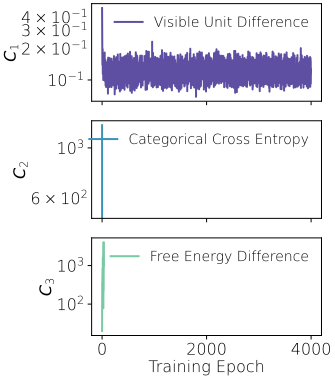

In [11]:
fig,ax = plt.subplots(3,1,figsize=(4,6), sharex=True)

labels = ['Visible Unit Difference','Categorical Cross Entropy','Free Energy Difference']
for i,cax in enumerate(ax):
    cax.semilogy(C[:,i],color=colors[i], label=labels[i])
    cax.set_ylabel(f'$C_{{{i+1}}}$')
    cax.legend()

ax[-1].set_xlabel('Training Epoch')

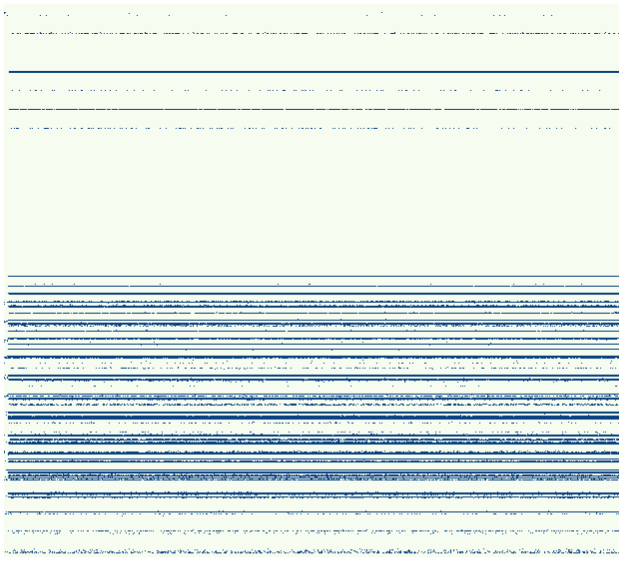

In [13]:
from IPython.display import clear_output
from time import sleep

num_samples = 1000

# for plotting
test_samples = np.zeros([D,num_samples])
skip_steps = 5

vp = np.zeros(D)
h = np.zeros(nₕ)
hp = np.zeros(nₕ)

for j in range(num_samples):
    v,h,vp,hp = RBM_sequence(v,a,b,w,stop=False)
    
    test_samples[:,j] = v[0,:]
    
    # use the new v as a starting point for next step!
    v = np.copy(vp) 
    
    if j % skip_steps == 0 or j == num_samples-1:
        plt.figure(figsize=(15,10))
        clear_output(wait=True)
        plt.imshow(test_samples,origin='lower',interpolation='Nearest', cmap='GnBu')
        plt.axis('off')
        plt.show()

Finally, we can use this process to sample likely confurations at a given temperature. 

In [15]:
%%time
num_samples = 100000
store = 50
skip = int(num_samples/50)
store_samples = np.zeros([D,store])

count = 0
for j in tqdm(range(num_samples)):
    v,h,vp,hp = RBM_sequence(v,a,b,w,stop=False)
    
    if j % skip == 0:
        store_samples[:,count] = v[0,:]
        count += 1
    
    # use the new v as a starting point for next step!
    v = np.copy(vp)

  0%|          | 0/100000 [00:00<?, ?it/s]/lustre/haven/proj/UTK0154/local/envs/ml4s/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
100%|██████████| 100000/100000 [02:51<00:00, 583.30it/s]

CPU times: user 4min 53s, sys: 6min 29s, total: 11min 23s
Wall time: 2min 51s


Then, we can use that sample to see what configurations are proposed by the RBM.

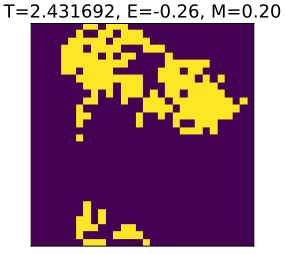

In [21]:
for i in range(len(v)):
# random_index = np.random.choice(range(len(x)))
    σ = np.array(v[i])
    σ = σ.reshape([L,L])

    # visualize
    clear_output(wait=True)
    plt.matshow(σ);
    plt.xticks([]);
    plt.yticks([]);
    E, M = get_props(σ)
    plt.title(f'T={T}, E={E:1.2f}, M={M:1.2f}')
    plt.show()

## Discussions

This technique can now be extended. We can train multiple RBMs at different temperature and the RBM should propose the most likely configuration at each temperature, does cutting down the time required for thermalization.

## References

1. Huang, L., & Wang, L. (2017). Accelerated Monte Carlo simulations with restricted Boltzmann machines. Physical Review B, 95(3).

2. Liu, J., Qi, Y., Meng, Z., & Fu, L. (2017). Self-learning Monte Carlo method. Physical Review B, 95(4).

